In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime 
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from tensorflow.keras import Sequential
from keras.layers import LSTM,Dense



In [2]:
tata = yf.download("TATASTEEL.NS", start="2020-01-02")
tata.to_csv(r'Downloads\tata.csv')

[*********************100%***********************]  1 of 1 completed


In [3]:
reliance = yf.download("RELIANCE.NS", start="2020-01-02")
reliance.to_csv(r'Downloads\reliance.csv')

[*********************100%***********************]  1 of 1 completed


In [4]:
lt = yf.download("LT.NS", start="2020-01-02")
lt.to_csv(r'Downloads\lt.csv')

[*********************100%***********************]  1 of 1 completed


In [5]:
company_list =[tata , reliance , lt]

In [6]:
company_list

[                  Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2020-01-02   47.200001   48.779999   47.200001   48.485001   20.547953   
 2020-01-03   48.299999   48.619999   47.945000   48.369999   20.499216   
 2020-01-06   48.000000   48.000000   47.055000   47.325001   20.056345   
 2020-01-07   47.549999   48.459999   47.355000   47.610001   20.177128   
 2020-01-08   47.165001   47.814999   46.700001   47.525002   20.141106   
 ...                ...         ...         ...         ...         ...   
 2022-09-06  107.400002  108.800003  106.050003  108.599998  108.599998   
 2022-09-07  107.550003  108.900002  107.099998  107.599998  107.599998   
 2022-09-08  108.400002  108.400002  105.349998  105.849998  105.849998   
 2022-09-09  107.000000  107.349998  105.500000  105.699997  105.699997   
 2022-09-12  106.800003  107.949997  106.500000  107.750000  107.750000   
 
                Volume 

In [7]:
for each_stock in company_list:
    each_stock.drop([ 'High', 'Low', 'Adj Close', 'Volume'], axis =1,inplace =True)

In [8]:
for each_stock in company_list:
    each_stock['Change'] = each_stock['Close']-each_stock['Open']

In [9]:
for each_stock in company_list:
    each_stock.loc[each_stock.Change >0, 'Gains'] = 1 
    each_stock.loc[each_stock.Change <0, 'Gains'] = -1 
    each_stock.loc[each_stock.Change ==0, 'Gains'] = 0 

In [10]:
tata.head()

,Open,Close,Change,Gains
Date,,,,
2020-01-02,47.200001,48.485001,1.285000,1.0
2020-01-03,48.299999,48.369999,0.070000,1.0
2020-01-06,48.000000,47.325001,-0.674999,-1.0
2020-01-07,47.549999,47.610001,0.060001,1.0
2020-01-08,47.165001,47.525002,0.360001,1.0


In [11]:
reliance.head()

,Open,Close,Change,Gains
Date,,,,
2020-01-02,1497.802368,1520.883545,23.081177,1.0
2020-01-03,1518.605103,1522.716187,4.111084,1.0
2020-01-06,1505.727173,1487.400879,-18.326294,-1.0
2020-01-07,1504.736572,1510.284058,5.547485,1.0
2020-01-08,1500.774170,1498.941528,-1.832642,-1.0


In [12]:
lt.head()

,Open,Close,Change,Gains
Date,,,,
2020-01-02,1312.000000,1345.300049,33.300049,1.0
2020-01-03,1344.949951,1335.050049,-9.899902,-1.0
2020-01-06,1331.000000,1316.750000,-14.250000,-1.0
2020-01-07,1328.000000,1320.500000,-7.500000,-1.0
2020-01-08,1302.000000,1291.550049,-10.449951,-1.0


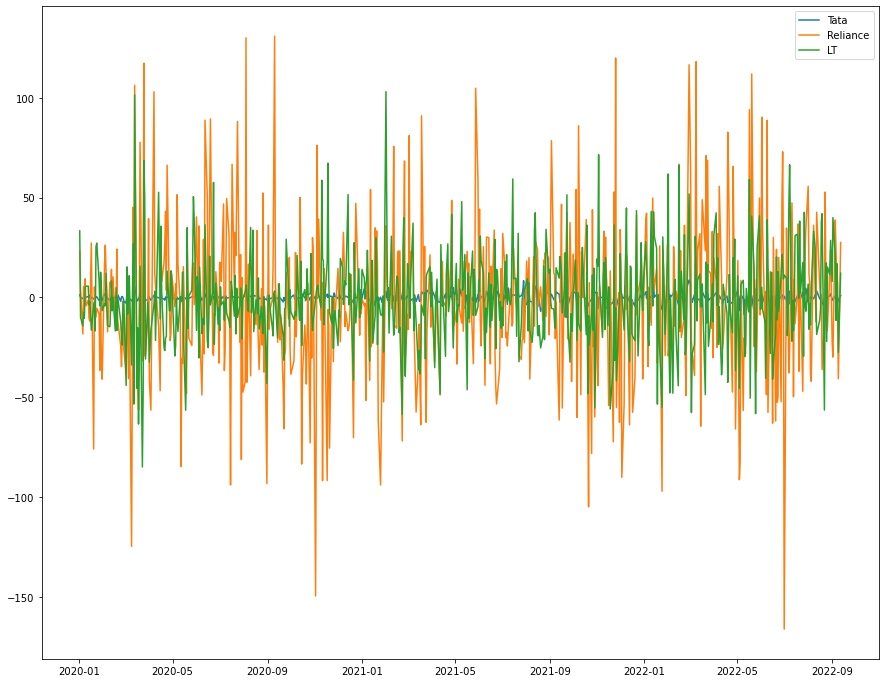

In [13]:
plt.figure(figsize = (15,12))

plt.plot(tata["Change"], label='Tata')
plt.plot(reliance["Change"], label='Reliance')
plt.plot(lt["Change"], label='LT')


plt.legend(loc='best')
plt.show()

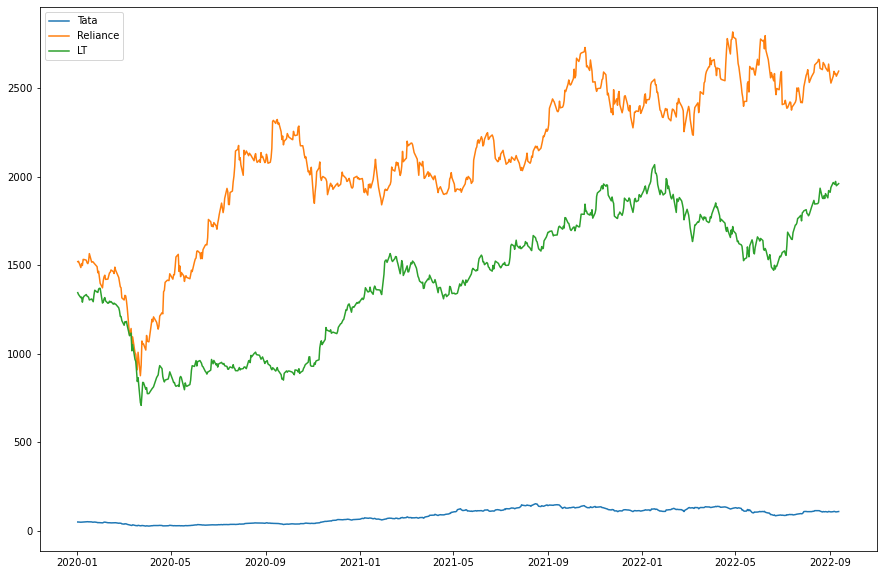

In [14]:
plt.figure(figsize = (15,10))

plt.plot(tata["Close"], label='Tata')
plt.plot(reliance["Close"], label='Reliance')
plt.plot(lt["Close"], label='LT')


plt.legend(loc='best')
plt.show()

In [15]:
scaler = MinMaxScaler()
company_list2 = scaler.fit_transform(each_stock.iloc[:,1:])

In [16]:
num_companies = 3
look_back = 60
forward_days = 10
num_periods = 10
step_size = 40

In [17]:
#split in Train and Test
division = len(company_list2) - num_periods*forward_days

array_test = company_list2[division-look_back:]
array_train = company_list2[:division]

In [18]:
#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def processData(data, look_back, forward_days,num_companies,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [19]:
X_test,y_test = processData(array_test,look_back,forward_days,num_companies,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_days,num_companies)
y = np.array([list(x.ravel()) for x in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

In [20]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)
#(Sample,Timestep,Features)

(400, 60, 3)
(101, 60, 3)
(10, 60, 3)
(400, 30)
(101, 30)
(10, 30)


In [21]:
model = Sequential()

model.add(LSTM (500,input_shape=(look_back,num_companies), return_sequences=True))
model.add(LSTM(300,input_shape=(500,1)))
model.add(Dense(forward_days * num_companies))
model.compile(loss='mean_squared_error', optimizer='adam' )

history = model.fit(X_train,y_train,epochs=50,validation_data=(X_validate,y_validate),shuffle=True,batch_size=1, verbose=2)

Epoch 1/50
400/400 - 82s - loss: 0.1006 - val_loss: 0.0932 - 82s/epoch - 206ms/step
Epoch 2/50
400/400 - 81s - loss: 0.0922 - val_loss: 0.0934 - 81s/epoch - 202ms/step
Epoch 3/50
400/400 - 80s - loss: 0.0907 - val_loss: 0.0924 - 80s/epoch - 199ms/step
Epoch 4/50
400/400 - 79s - loss: 0.0901 - val_loss: 0.0913 - 79s/epoch - 198ms/step
Epoch 5/50
400/400 - 79s - loss: 0.0891 - val_loss: 0.0910 - 79s/epoch - 197ms/step
Epoch 6/50
400/400 - 79s - loss: 0.0888 - val_loss: 0.0885 - 79s/epoch - 198ms/step
Epoch 7/50
400/400 - 79s - loss: 0.0889 - val_loss: 0.0899 - 79s/epoch - 198ms/step
Epoch 8/50
400/400 - 704s - loss: 0.0885 - val_loss: 0.0893 - 704s/epoch - 2s/step
Epoch 9/50
400/400 - 77s - loss: 0.0887 - val_loss: 0.0905 - 77s/epoch - 192ms/step
Epoch 10/50
400/400 - 76s - loss: 0.0886 - val_loss: 0.0901 - 76s/epoch - 191ms/step
Epoch 11/50
400/400 - 83s - loss: 0.0881 - val_loss: 0.0900 - 83s/epoch - 206ms/step
Epoch 12/50
400/400 - 79s - loss: 0.0882 - val_loss: 0.0897 - 79s/epoch - 1

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 500)           1008000   
                                                                 
 lstm_1 (LSTM)               (None, 300)               961200    
                                                                 
 dense (Dense)               (None, 30)                9030      
                                                                 
Total params: 1,978,230
Trainable params: 1,978,230
Non-trainable params: 0
_________________________________________________________________


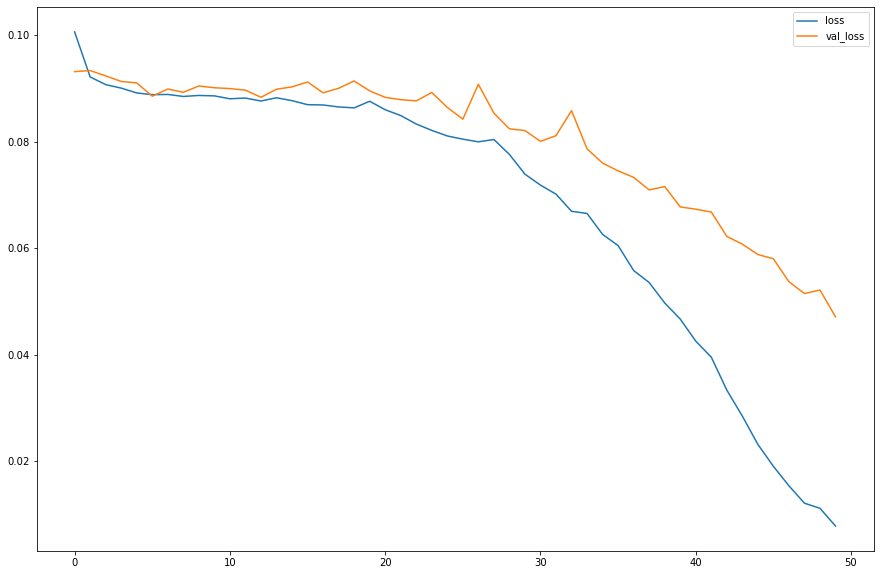

In [23]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [24]:
X_test,y_test = processData(array_test,look_back,forward_days,num_companies,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

Xt = model.predict(X_test)
Xt.shape

1/1 [==============================] - 1s 860ms/step


(10, 30)

In [25]:
def do_inverse_transform(output_result,num_companies = 3):
    #From input/output nootbook: apply makeup, use scl.inverse_transform and remove makeup
    
    #transform to input shape
    original_matrix_format = []
    for result in output_result:
        #do inverse transform
        original_matrix_format.append(scaler.inverse_transform([result[x:x+num_companies] for x in range(0, len(result), num_companies)]))
    original_matrix_format = np.array(original_matrix_format)
    
    #restore to original shape
    for i in range(len(original_matrix_format)):
        output_result[i] = original_matrix_format[i].ravel()

    return output_result

In [26]:
def prediction_by_step_by_company(raw_model_output, num_companies):
    matrix_prediction = []
    for i in range(0,num_companies):
        matrix_prediction.append([[lista[j] for j in range(i,len(lista),num_companies)] for lista in raw_model_output])
    return np.array(matrix_prediction)

In [27]:
Xt = do_inverse_transform(Xt)

MP = prediction_by_step_by_company(Xt, num_companies)
MP.shape

(3, 10, 10)

In [28]:
def target_by_company(raw_model_output, num_companies):
    matrix_target = [[] for x in range(num_companies)]
    
    for output in raw_model_output:
        for i in range (num_companies):
            for j in range(0,len(output),num_companies):
                matrix_target[i].append(output[i+j])
    return np.array(matrix_target)

In [29]:
Yt = do_inverse_transform(y_test)

MT = target_by_company(Yt, num_companies)
MT.shape

(3, 100)

In [32]:
colors = ['r','g','c','m','y','k']
companies_names = ['tata','reliance','lt']

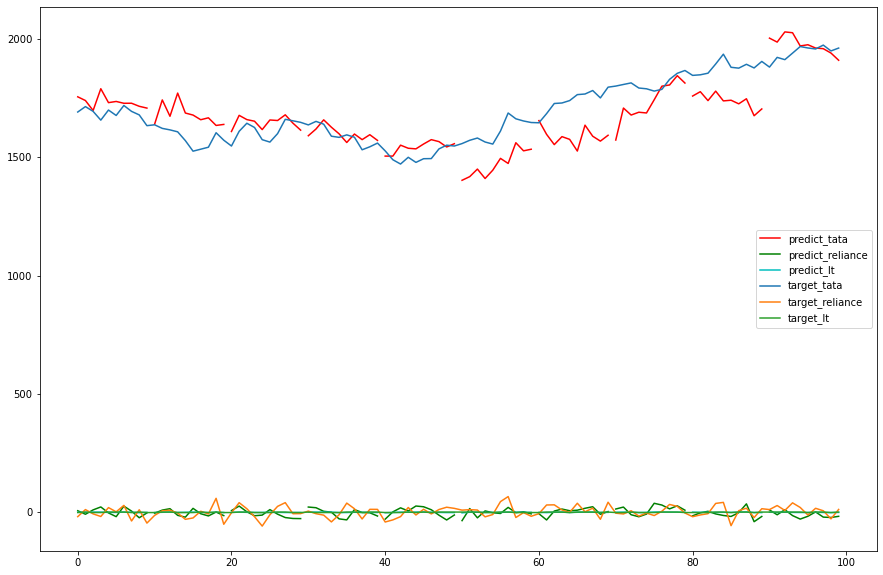

In [33]:
plt.figure(figsize = (15,10))

companies_to_show = [0,1,2] #select one of [0,1,2] to see only one


    
for id_company in companies_to_show:
    for i in range(0,len(MP[id_company])):
        plt.plot([x + i*forward_days for x in range(len(MP[id_company][i]))], MP[id_company][i], color=colors[id_company])
    plt.plot(0,MP[id_company][0][0] ,color=colors[id_company], label='predict_{}'.format(companies_names[id_company])) #only to place the label

for id_company in companies_to_show:
    plt.plot(MT[id_company], label='target_{}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()